# Multiple Linear Regression Model

In [1]:
# Installations
# !pip install keras
# !pip install tensorflow
# !pip install sklearn --upgrade
# !pip install joblib

In [2]:
import warnings
warnings.simplefilter('ignore')

# Load dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set the same starting seed number for numpy.random so the results are reproducible
from numpy.random import seed
seed(42)

## Basic Data Cleaning

In [3]:
# Read and clean the data
primary = os.path.join('..','resources','primary_indicators.csv')
education = os.path.join('..','resources','education_df.csv')
gender = os.path.join('..','resources','gender_df.csv')

primary_df = pd.read_csv(primary)
education_df = pd.read_csv(education)
gender_df = pd.read_csv(gender)

education_df = education_df.loc[education_df["indicator_name"] == "Education Index"]
gender_df = gender_df.loc[gender_df["indicator_name"] == "Gender Inequality Index"]

# all_dfs = [primary_df, education_df, gender_df]
# df = pd.concat(all_dfs)

df = primary_df
df.tail()

,Unnamed: 0,country_name,indicator_name,year,value,hdi
29361,3556025,Liechtenstein,"Population, total",2017,3.780000e+04,0.916
29362,3556433,Andorra,GDP (current US$),2018,3.236544e+09,0.857
29363,3556436,Andorra,GDP per capita (current US$),2018,4.202976e+04,0.857
29364,3556457,Andorra,"Population, total",2018,7.700600e+04,0.857
29365,3556571,Liechtenstein,"Population, total",2018,3.791000e+04,0.917


In [4]:
# Pivot table with indicators/features as column names
pivot_df = df.pivot_table(index=["country_name","year","hdi"], columns=["indicator_name"], values=["value"])

# Flatten pivot table
pivot_df.columns = pivot_df.columns.to_series().str.join(' ')
pivot_df.reset_index(inplace=True)

# ... dropping Employment column ...wrong indicator ...too late to change
pivot_df = pivot_df.drop(['value Employers, total (% of total employment) (modeled ILO estimate)'], axis=1)

# Rename columns
pivot_df = pivot_df.rename(columns={"value Life expectancy at birth, total (years)": "Life expectancy",
                                    "value Agriculture, forestry, and fishing, value added (% of GDP)": "Agriculture (% GDP)",
                                    "value GDP (current US$)": "GDP (USD)",
                                    "value GDP per capita (current US$)": "GDP per capita",
                                    "value GNI per capita, Atlas method (current US$)": "GNI per capita",
                                    "value Population, total": "Population",
#                                     "value Education Index": "Education",
#                                     "value Gender Inequality Index": "Gender Inequality",
                                   })
pivot_df.head()

,country_name,year,hdi,Agriculture (% GDP),GDP (USD),GDP per capita,GNI per capita,Life expectancy,Population
0,Afghanistan,1990,0.298,NaN,NaN,NaN,NaN,50.331,12412308.0
1,Afghanistan,1991,0.304,NaN,NaN,NaN,NaN,50.999,13299017.0
2,Afghanistan,1992,0.312,NaN,NaN,NaN,NaN,51.641,14485546.0
3,Afghanistan,1993,0.308,NaN,NaN,NaN,NaN,52.256,15816603.0
4,Afghanistan,1994,0.303,NaN,NaN,NaN,NaN,52.842,17075727.0


In [5]:
# Drop rows with null values
print(pivot_df.shape)
pivot_df = pivot_df.dropna()
print(pivot_df.shape)

pivot_df["hdi"] = pivot_df["hdi"].astype('float')

pivot_df.reset_index(inplace=True)
pivot_df.head()

(4395, 9)
(3735, 9)


,index,country_name,year,hdi,Agriculture (% GDP),GDP (USD),GDP per capita,GNI per capita,Life expectancy,Population
0,19,Afghanistan,2009,0.447,29.297501,1.243909e+10,438.076034,450.0,60.484,28394813.0
1,20,Afghanistan,2010,0.464,26.210069,1.585657e+10,543.303042,510.0,61.028,29185507.0
2,21,Afghanistan,2011,0.465,23.743664,1.780428e+10,591.162346,530.0,61.553,30117413.0
3,22,Afghanistan,2012,0.479,24.390874,2.000162e+10,641.872034,630.0,62.054,31161376.0
4,23,Afghanistan,2013,0.485,22.810663,2.056105e+10,637.165044,660.0,62.525,32269589.0


In [6]:
countries = pivot_df.loc[pivot_df["country_name"] == "United States"]
countries.tail()

,index,country_name,year,hdi,Agriculture (% GDP),GDP (USD),GDP per capita,GNI per capita,Life expectancy,Population
3594,4240,United States,2013,0.914,1.333514,1.678485e+13,53106.909770,53940.0,78.741463,316057727.0
3595,4241,United States,2014,0.915,1.188656,1.752175e+13,55032.957998,55830.0,78.841463,318386421.0
3596,4242,United States,2015,0.917,1.042561,1.821930e+13,56803.472433,56720.0,78.690244,320742673.0
3597,4243,United States,2016,0.919,0.940404,1.870719e+13,57904.201961,57160.0,78.539024,323071342.0
3598,4244,United States,2017,0.919,0.916479,1.948539e+13,59927.929834,59030.0,78.539024,325147121.0


In [7]:
filepath = os.path.join('..','static','primary_pivot.csv')
pivot_df.to_csv(filepath, header = True)

In [8]:
# Specify indicator(s)
indicators = ["Life expectancy",
              "Agriculture (% GDP)",
              "GDP per capita",
              "GNI per capita",
              "Population"]

''' NOTE: Do not include Education and Gender Inequality yet, 
as we have found that they have significantly fewer data points and 
affect the score of the combined multilinear regression model(s).
Instead, please use the linear regression model found in linear.ipynb.
''' 

# Initialize features array
X = []

# For each row in the df
for row in range(len(pivot_df)):

    point = []

    # Append each indicator value to the data point
    for i in range(len(indicators)):
        point.append(pivot_df[indicators[i]][row])
        
    # Append the row to the features array
    X.append(point)

X

[[60.484, 29.2975010547259, 438.076034406941, 450.0, 28394813.0],
 [61.028, 26.2100685374552, 543.303041863931, 510.0, 29185507.0],
 [61.553, 23.743663987754307, 591.16234645088, 530.0, 30117413.0],
 [62.054, 24.390873626371, 641.872033785411, 630.0, 31161376.0],
 [62.525, 22.8106627361766, 637.16504385598, 660.0, 32269589.0],
 [62.966, 22.137041371957398, 613.856332882312, 630.0, 33370794.0],
 [63.377, 20.6343227166798, 578.466352941708, 600.0, 34413603.0],
 [63.76300000000001, 21.0810862110389, 547.228110150363, 570.0, 35383128.0],
 [64.13, 20.466505165881, 556.302138508508, 550.0, 36296400.0],
 [72.495, 36.4107030664902, 1009.9776675210601, 890.0, 3168033.0],
 [72.83800000000002, 31.5433425577314, 717.380567391734, 800.0, 3148281.0],
 [73.208, 28.7855755984545, 813.790263555599, 860.0, 3128530.0],
 [73.587, 25.9188725068285, 1033.2416930932002, 950.0, 3108778.0],
 [73.955, 24.5153606554554, 1126.68331762741, 1100.0, 3089027.0],
 [74.288, 22.716196702944497, 1281.65939343074, 1280.0,

In [9]:
# Flatten the data into arrays
X = np.array(X)

y = np.array(pivot_df["hdi"])
y = y.reshape(-1, 1)

print(X.shape)
print(y.shape)

(3735, 5)
(3735, 1)


## Plot the Data

In [10]:
# fig, ax = plt.subplots()
# ax.scatter(X, y)
# plt.xlabel(indicator)
# plt.ylabel("HDI")
# plt.show()

## Data Preprocessing for ML

In [11]:
# Split into Test and Train data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [12]:
# Scale the data
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [13]:
# Transform the training and test data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

## Creating the Model

### Multiple Linear Regression Model

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [16]:
# Create the model using LinearRegression
linear = LinearRegression()

# Train the model
linear.fit(X_train_scaled, y_train_scaled)

# Use our model to make predictions
predictions = linear.predict(X_test_scaled)

# Score the model
training_score = linear.score(X_train_scaled, y_train_scaled)
testing_score = linear.score(X_test_scaled, y_test_scaled)
r2 = linear.score(X_test_scaled, y_test_scaled)
mse = mean_squared_error(y_test_scaled, predictions)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")
print(f"R2 Score: {r2}")
print(f"Mean Squared Error (MSE): {mse}")
# print(f"Linear Coefficient: {linear.coef_[0][0]}")
# print(f"y-Axis Intercept: {linear.intercept_[0]}")

Training Score: 0.9187339669420508
Testing Score: 0.9112354309042927
R2 Score: 0.9112354309042927
Mean Squared Error (MSE): 0.08158744726252752


### Predicting HDI value

In [ ]:
feed_values = [78.5, 0.92, 59928, 59030, 325147121]

X_scaled = X_scaler.transform([feed_values])
y_scaled = linear.predict(X_scaled)
predicted_y = y_scaler.inverse_transform(y_scaled)
predicted_HDI = predicted_y[0][0]

predicted_HDI

### Plot the Model

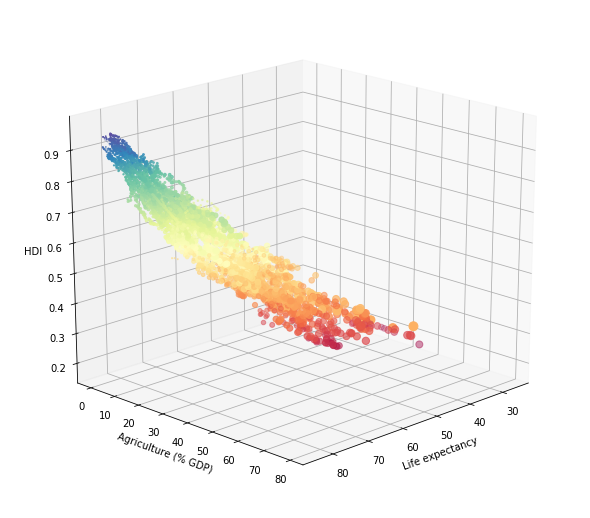

In [17]:
# # Plot the model
# x_min = np.array([[X_train_scaled.min()]])
# x_max = np.array([[X_train_scaled.max()]])
# y_min = linear.predict(x_min)
# y_max = linear.predict(x_max)
# plt.scatter(X_train_scaled, y_train_scaled, c='blue')
# plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')
# plt.title("Linear Regression Model")
# plt.xlabel(f"{indicator} (Scaled)")
# plt.ylabel("HDI (Scaled)")
# plt.show()

# create some fake data
X = np.array(pivot_df['Life expectancy'])
Y = np.array(pivot_df['Agriculture (% GDP)'])
Z = np.array(pivot_df['hdi'])


from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8, 7))
axes = Axes3D(fig, elev=20, azim=45)
axes.scatter(X, Y, Z, s=Y, c=Z, cmap=plt.cm.get_cmap("Spectral"))
axes.set_xlabel('Life expectancy')
axes.set_ylabel('Agriculture (% GDP)')
axes.set_zlabel('HDI')
plt.show()

### Plot the Residuals

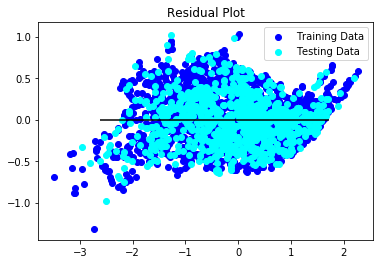

In [18]:
# # Plot the residuals
# y_train_predict = linear.predict(X_train_scaled)
# y_test_predict = linear.predict(X_test_scaled)
# y_train_residual = linear.predict(X_train_scaled) - y_train_scaled
# y_test_residual = linear.predict(X_test_scaled) - y_test_scaled

# plt.scatter(y_train_predict, y_train_residual, c="blue", label="Training Data")
# plt.scatter(y_test_predict, y_test_residual, c="orange", label="Testing Data")
# plt.legend()
# plt.hlines(y=0, xmin=y_train_predict.min(), xmax=y_train_predict.max())
# plt.title("Residual Plot")
# plt.xlabel("Prediction")
# plt.ylabel("Residual")
# plt.show()
plt.scatter(linear.predict(X_train_scaled), linear.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(linear.predict(X_test_scaled), linear.predict(X_test_scaled) - y_test_scaled, c="aqua", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()